# Notebook 4: Machine Learning Modeling of Milling Process Data

In the previous notebook, we performed a **correlation analysis** to explore relationships between process signals such as currents, forces, and cutting parameters.

---


## Data Splitting and Test Sets

After cleaning and preprocessing, a total of **40 out of 43 conducted experiments** were combined into a single dataset. This dataset was then split into:

- **70% Training set (`df_Train`)**  
- **15% Validation set (`df_Val`)**  
- **15% Test set 1 (`df_Test`)**

In addition to this, **one experiment** were **not included** in the main dataset. Instead,  it was kept separate as a **second dedicated test set** (`df_Test_D6D6D8`).

### Purpose of the Two Test Sets:

- **Test Set 1** (`df_Test`):  
  Contains smaller segments from multiple experiments.  
  → Used to evaluate model performance under **varying tool diameters**.

- **Test Set 2** (`df_Test_D6D6D8`):  
  Consists of **entire, previously unseen experiments**.  
  → Used to assess the model's **generalization capability on complete trials**.

This dual test set approach allows for both **fine-grained** and **realistic** model evaluation scenarios.

---

### Goal of this Notebook:

In this notebook, we will develop and evaluate **machine learning model** Random forest to  predcit the spindle current and evluate the model .....





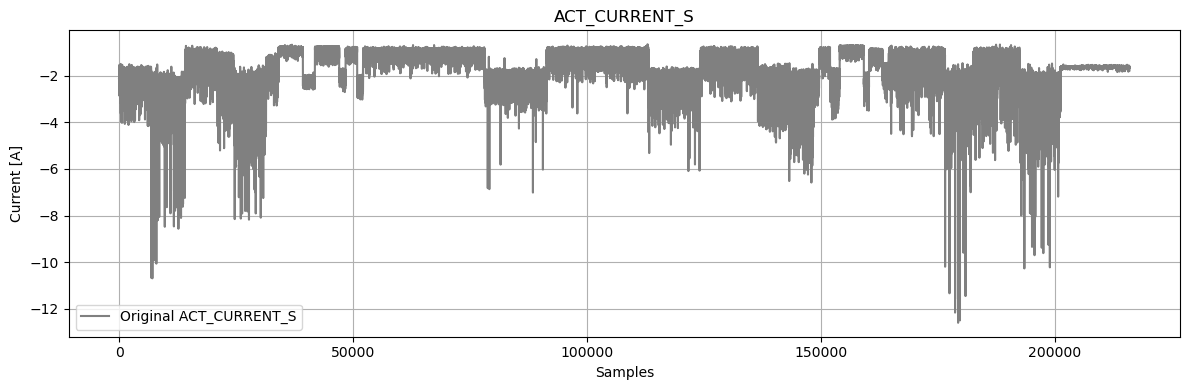

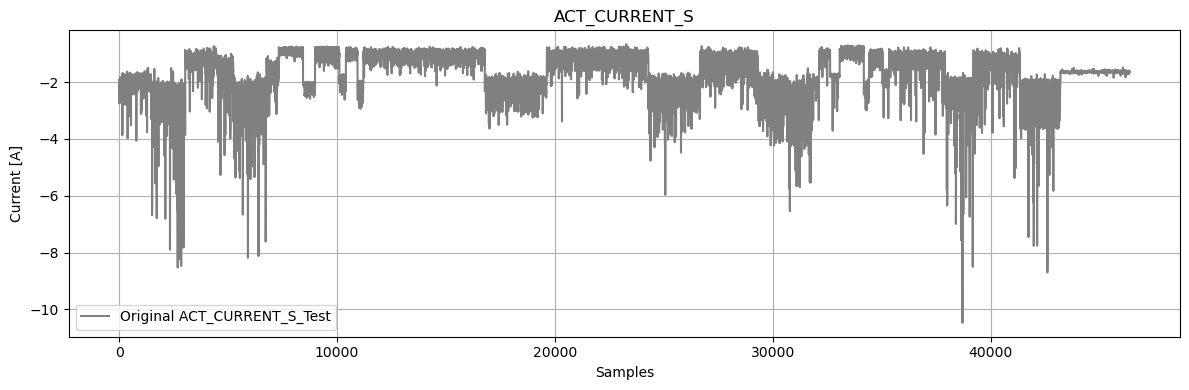

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

files = sorted(glob.glob("Rough_Train_New*.csv.gz"))
dfs = [pd.read_csv(f, compression="gzip") for f in files]
df_Train = pd.concat(dfs, ignore_index=True)
df_Test = pd.read_csv("Rough_Test_New.csv.gz", compression="gzip")
df_Test_2 = pd.read_csv("Rough_Test_D6D6D8.csv.gz", compression="gzip")
df_Val = pd.read_csv("Rough_Val_New.csv.gz", compression="gzip")

# Plot: Spindle current Training set
plt.figure(figsize=(12, 4))
plt.plot(df_Train['ACT_CURRENT_S'], color='gray', label='Original ACT_CURRENT_S')
plt.title('ACT_CURRENT_S')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Spindle current Test set
plt.figure(figsize=(12, 4))
plt.plot(df_Test['ACT_CURRENT_S'], color='gray', label='Original ACT_CURRENT_S_Test')
plt.title('ACT_CURRENT_S')
plt.xlabel('Samples')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




## Feature and Target Distribution Alignment

During the data splitting process, special care was taken to ensure that the **distributions of both the features and the target variables** in the training, validation, and test sets remained consistent with those in the **original full dataset**.

This was achieved by preserving a **similar proportion of data from all experiments** across each subset. This approach helps to avoid bias and ensures that the model is trained and evaluated on data that reflects the **full range of process conditions**.

Below, we visualize the distribution of selected features and target variables across the training, validation, and test sets to confirm this alignment.

The distributions of **spindle speed**, **width of cut (ae)**, **cutting speed**, and **spindle current** are consistent across all three subsets.  
The plots illustrate that the data was split in a **balanced and representative manner**, ensuring the reliability of the model's training and evaluation process.


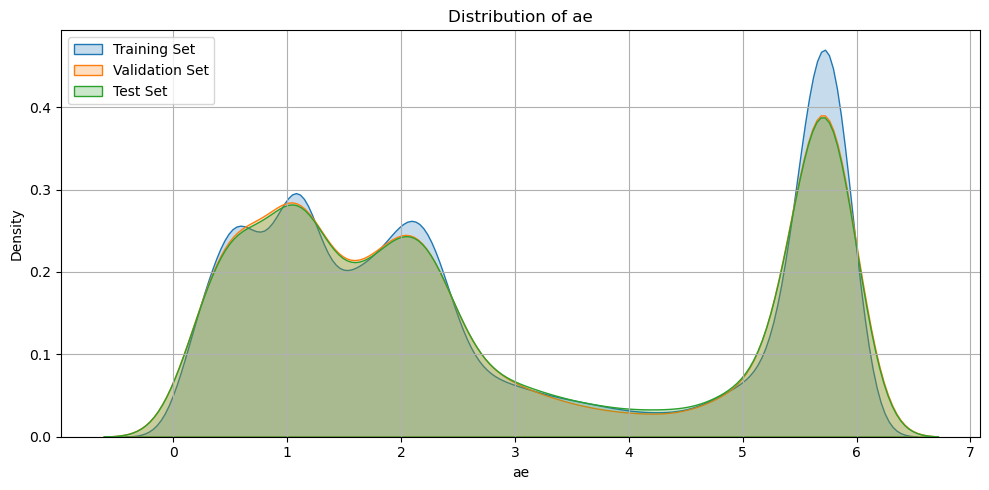

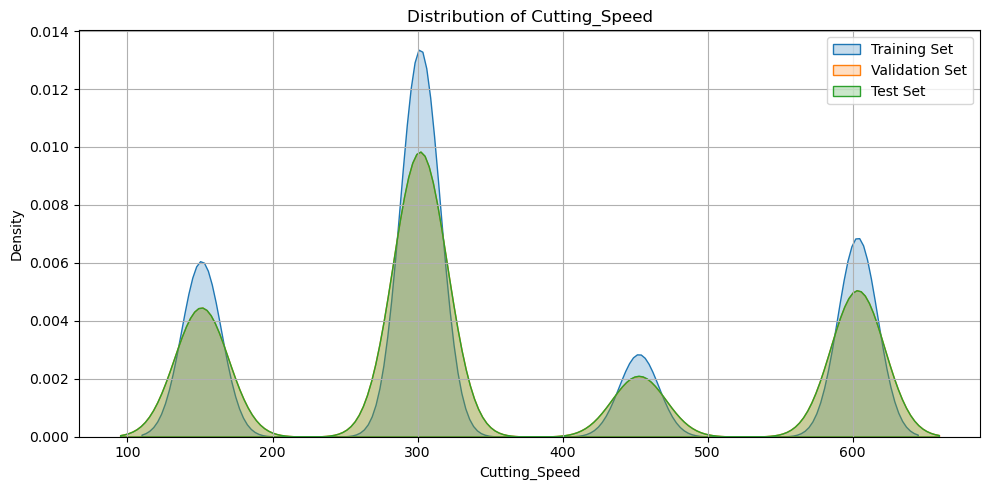

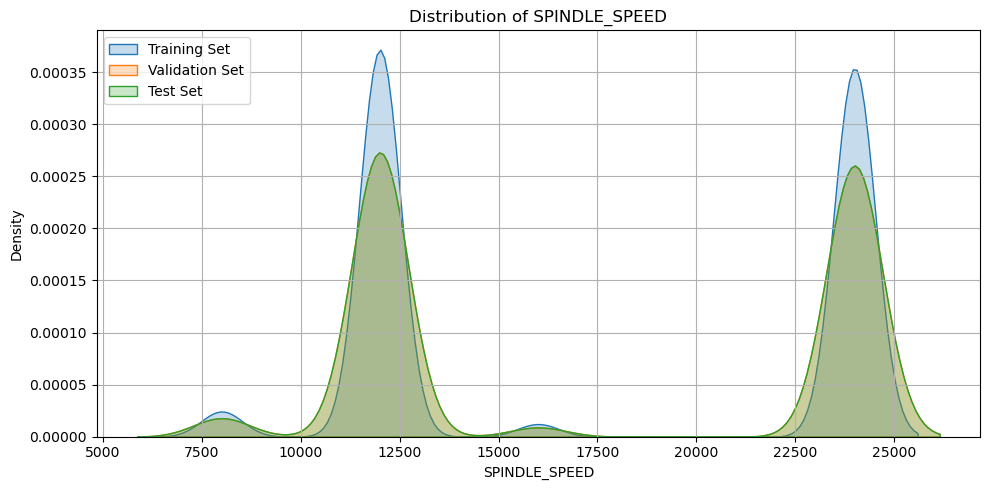

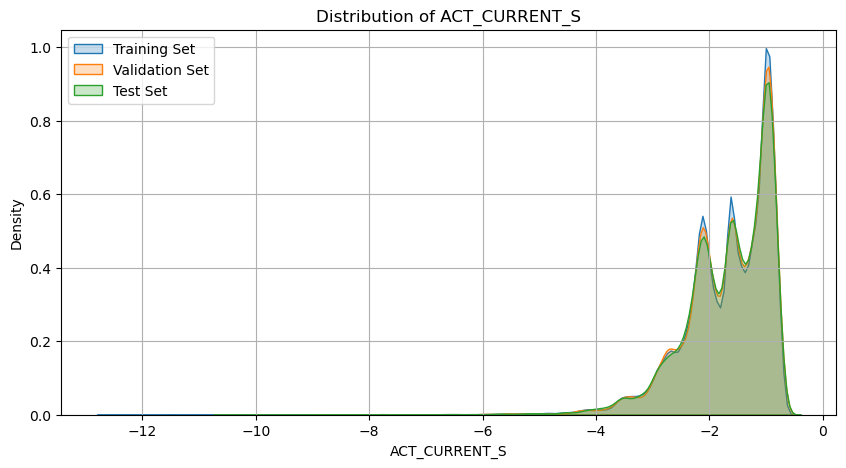

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a list of selected input features to visualize
selected_features = ['ae', 'Cutting_Speed', 'SPINDLE_SPEED']

# Plot the distribution of each selected feature for Train, Validation, and Test sets
for feature in selected_features:
    plt.figure(figsize=(10, 5))
    
    # Kernel Density Estimation (KDE) plot for each dataset
    sns.kdeplot(df_Train[feature], label='Training Set', fill=True)
    sns.kdeplot(df_Val[feature], label='Validation Set', fill=True)
    sns.kdeplot(df_Test[feature], label='Test Set', fill=True)
    
    # Plot styling
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# Define a list of target variables (here only the spindle current)
target_variables = ['ACT_CURRENT_S']

# Plot the distribution of the target variable for Train, Validation, and Test sets
for target in target_variables:
    plt.figure(figsize=(10, 5))
    
    sns.kdeplot(df_Train[target], label='Training Set', fill=True)
    sns.kdeplot(df_Val[target], label='Validation Set', fill=True)
    sns.kdeplot(df_Test[target], label='Test Set', fill=True)
    
    plt.title(f'Distribution of {target}')
    plt.xlabel(target)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
plt.show()


## Explanation of the Solution

### What the Code Does:

- **Data Check**: Ensures there is no overlap between training and test sets.
- **Model Setup**: A Random Forest Regressor was configured using optimized hyperparameters.
- **Training**: The model was trained on the main training dataset (`df_Train`).
- **Evaluation**: The trained model was tested on two datasets:
  - **Test Set 1**: Partial sequences from multiple experiments.
  - **Test Set 2**: Complete, previously unseen experiment.
- **Metrics**: For both test sets, the model performance was measured using R², MAE, and MSE.
- **Visualization**:
  - Time series plots of actual vs predicted spindle current.
  - Scatter plots showing prediction accuracy and fit line.
- **Feature Analysis**: The most important input features were identified and ranked.

This workflow demonstrates how machine learning can be applied to real manufacturing data to model and understand spindle behavior during cutting processes.


No overlap between training and test data.

Training Random Forest model for ACT_CURRENT_S...

Training completed in 0.43 minutes.


Evaluating on Test Set 1...

Test Set 1 R² Score: 0.9922
Test Set 1 MAE: 0.0318
Test Set 1 MSE: 0.0051


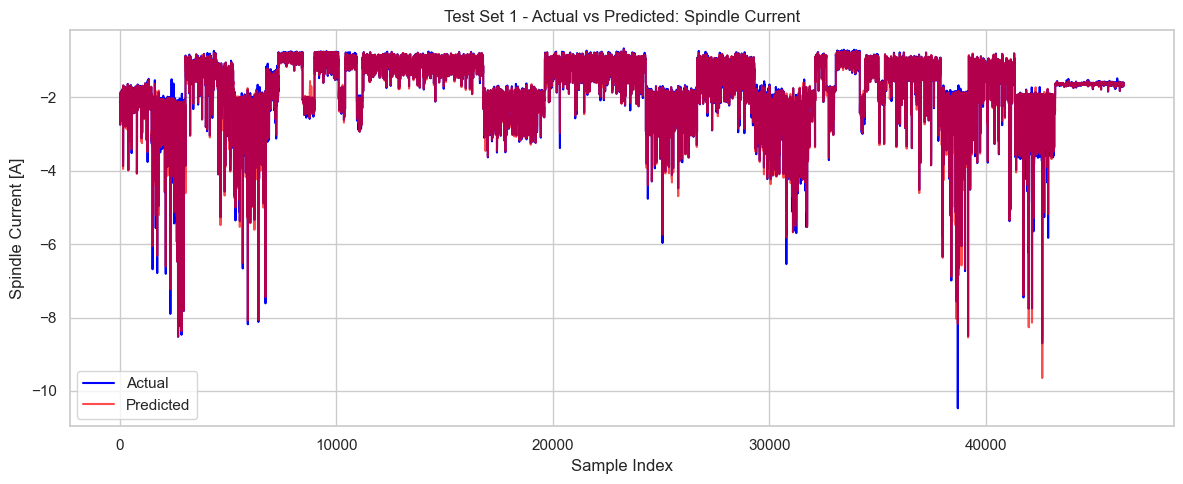

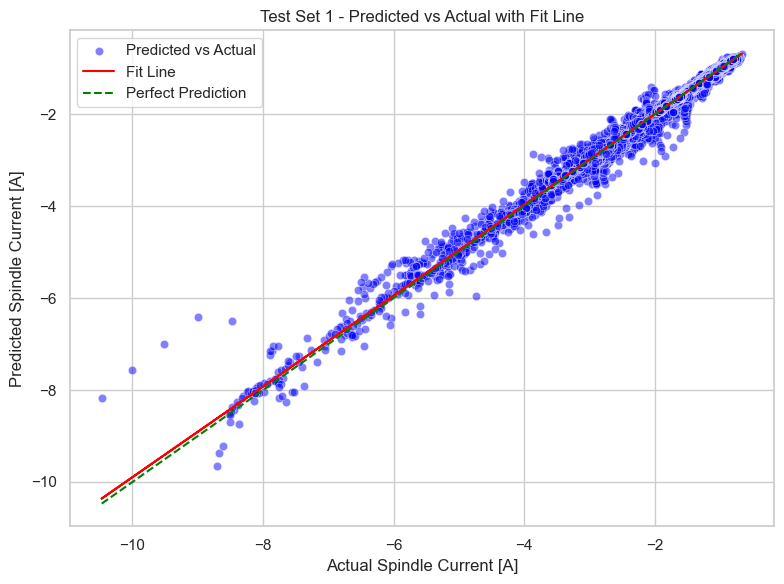


Evaluating on Test Set 2...

Test Set 2 R² Score: 0.9442
Test Set 2 MAE: 0.1065
Test Set 2 MSE: 0.0355


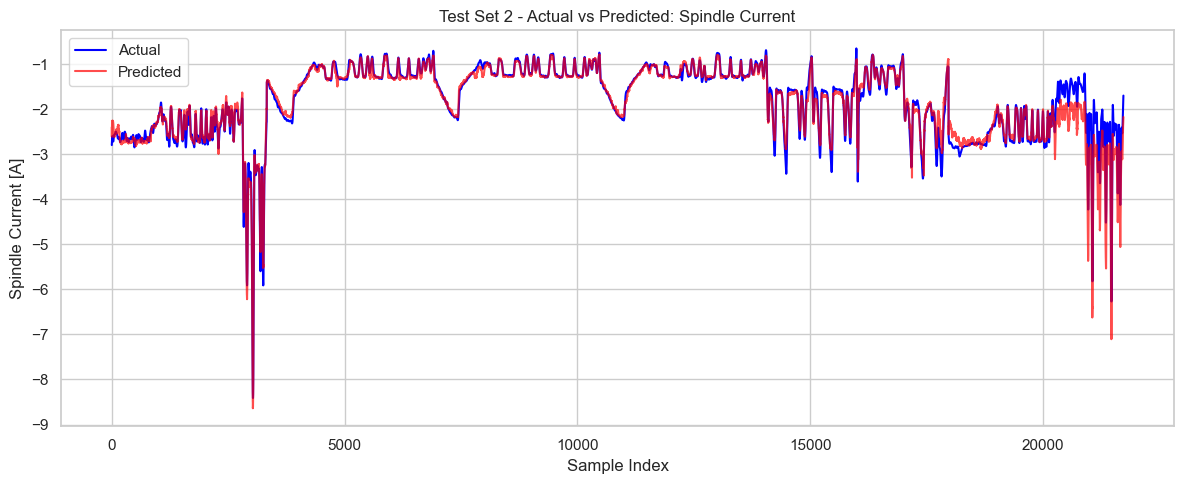

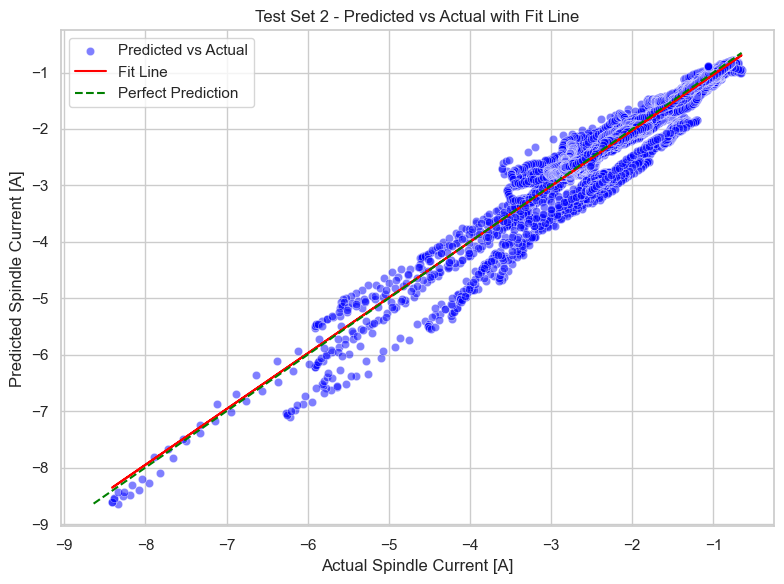


Top Features for Predicting ACT_CURRENT_S:
                              Feature  Importance
1                       SPINDLE_SPEED    0.235017
13                                 Qw    0.185122
11                      Cutting_Speed    0.183929
14                              F_xyz    0.097404
2                                Fz_N    0.058987
9                           Feed_Rate    0.054015
7   MultiDexel:GridZ-EngagementHeight    0.036231
12                                 ae    0.027842
5   MultiDexel:GridX-EngagementHeight    0.025935
6   MultiDexel:GridY-EngagementHeight    0.022523
3                                Fy_N    0.018371
4                                Fx_N    0.017848
8                       Tool_Diameter    0.015184
0                  ACTIVE_TOOL_LENGTH    0.011612
10                     Feed_per_Tooth    0.009981


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import time


# Ensure consistent plots
sns.set(style="whitegrid")

# Check for overlap between training and test data
overlap = pd.merge(df_Train, df_Test, how='inner')  # Inner join to find overlapping rows
if not overlap.empty:
    print("There is overlap between training and test data! Review the overlapping rows.")
    print(overlap)
else:
    print("No overlap between training and test data.")

# Define the target variable and feature list
target_variables = ['ACT_CURRENT_S']
features = [
    'ACTIVE_TOOL_LENGTH', 'SPINDLE_SPEED', 'Fz_N', 'Fy_N', 'Fx_N',
    'MultiDexel:GridX-EngagementHeight', 'MultiDexel:GridY-EngagementHeight', 
    'MultiDexel:GridZ-EngagementHeight', 'Tool_Diameter', 'Feed_Rate', 
    'Feed_per_Tooth', 'Cutting_Speed', 'ae', 'Qw', 'F_xyz'
]

# Best hyperparameters from previous tuning
best_params = {
    'n_estimators': 239,
    'max_depth': 59,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

# Dictionary to store feature importances
feature_importance_dict = {}

# Test sets to evaluate
test_sets = {
    "Test Set 1": df_Test,
    "Test Set 2": df_Test_2
}

# Training data
X_train = df_Train[features]
y_train = df_Train['ACT_CURRENT_S']

# Initialize and train the model once
print(f"\nTraining Random Forest model for ACT_CURRENT_S...\n")
start_time = time.time()

model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

end_time = time.time()
print(f"Training completed in {((end_time - start_time) / 60):.2f} minutes.\n")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Save to dictionary
feature_importance_dict['ACT_CURRENT_S'] = feature_importances

# Evaluate on each test set
for test_name, df_test in test_sets.items():
    print(f"\nEvaluating on {test_name}...\n")

    X_test = df_test[features]
    y_test = df_test['ACT_CURRENT_S'].values
    y_pred = model.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{test_name} R² Score: {r2:.4f}")
    print(f"{test_name} MAE: {mae:.4f}")
    print(f"{test_name} MSE: {mse:.4f}")

    # --- Plot 1: Actual vs Predicted (Time Series Style) ---
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(f'{test_name} - Actual vs Predicted: Spindle Current')
    plt.xlabel('Sample Index')
    plt.ylabel('Spindle Current [A]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Scatter with Fit Line ---
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')

    # Fit regression line
    reg = LinearRegression().fit(y_test.reshape(-1, 1), y_pred.reshape(-1, 1))
    fit_line = reg.predict(y_test.reshape(-1, 1))
    plt.plot(y_test, fit_line, color='red', label='Fit Line')

    # Perfect diagonal
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Perfect Prediction')

    plt.title(f'{test_name} - Predicted vs Actual with Fit Line')
    plt.xlabel('Actual Spindle Current [A]')
    plt.ylabel('Predicted Spindle Current [A]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display overall feature importance
print("\nTop Features for Predicting ACT_CURRENT_S:")
print(feature_importances)
